# Testing Out Neural Network Regression

## Importing Necessary Libraries

In [43]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
from keras.layers import Dense, LeakyReLU
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

## Loading in the Dataset

In [44]:
csv_url = 'https://gist.github.com/NickyDCFP/d675b176350f6a1d54455ffc35e350f9/raw/' + \
          '220fdbc2aec82b8b3e33681e4465813c02b5fccf/Spotify_Youtube.csv'
csv_df = pd.read_csv(csv_url)
# This column may not be necessary (duplicate of index), may remove
csv_df.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)
#csv_df.head()

,ID,Artist,Url_spotify,Track,Album,Album_type,Uri,Danceability,Energy,Key,...,Url_youtube,Title,Channel,Views,Likes,Comments,Description,Licensed,official_video,Stream
0,0,Gorillaz,https://open.spotify.com/artist/3AA28KZvwAUcZu...,Feel Good Inc.,Demon Days,album,spotify:track:0d28khcov6AiegSCpG5TuT,0.818,0.705,6.0,...,https://www.youtube.com/watch?v=HyHNuVaZJ-k,Gorillaz - Feel Good Inc. (Official Video),Gorillaz,693555221.0,6220896.0,169907.0,Official HD Video for Gorillaz' fantastic trac...,True,True,1.040235e+09
1,1,Gorillaz,https://open.spotify.com/artist/3AA28KZvwAUcZu...,Rhinestone Eyes,Plastic Beach,album,spotify:track:1foMv2HQwfQ2vntFf9HFeG,0.676,0.703,8.0,...,https://www.youtube.com/watch?v=yYDmaexVHic,Gorillaz - Rhinestone Eyes [Storyboard Film] (...,Gorillaz,72011645.0,1079128.0,31003.0,The official video for Gorillaz - Rhinestone E...,True,True,3.100837e+08
2,2,Gorillaz,https://open.spotify.com/artist/3AA28KZvwAUcZu...,New Gold (feat. Tame Impala and Bootie Brown),New Gold (feat. Tame Impala and Bootie Brown),single,spotify:track:64dLd6rVqDLtkXFYrEUHIU,0.695,0.923,1.0,...,https://www.youtube.com/watch?v=qJa-VFwPpYA,Gorillaz - New Gold ft. Tame Impala & Bootie B...,Gorillaz,8435055.0,282142.0,7399.0,Gorillaz - New Gold ft. Tame Impala & Bootie B...,True,True,6.306347e+07
3,3,Gorillaz,https://open.spotify.com/artist/3AA28KZvwAUcZu...,On Melancholy Hill,Plastic Beach,album,spotify:track:0q6LuUqGLUiCPP1cbdwFs3,0.689,0.739,2.0,...,https://www.youtube.com/watch?v=04mfKJWDSzI,Gorillaz - On Melancholy Hill (Official Video),Gorillaz,211754952.0,1788577.0,55229.0,Follow Gorillaz online:\nhttp://gorillaz.com \...,True,True,4.346636e+08
4,4,Gorillaz,https://open.spotify.com/artist/3AA28KZvwAUcZu...,Clint Eastwood,Gorillaz,album,spotify:track:7yMiX7n9SBvadzox8T5jzT,0.663,0.694,10.0,...,https://www.youtube.com/watch?v=1V_xRb0x9aw,Gorillaz - Clint Eastwood (Official Video),Gorillaz,618480958.0,6197318.0,155930.0,The official music video for Gorillaz - Clint ...,True,True,6.172597e+08


## EDA ##

In [76]:
irrelevant_columns = ["Url_spotify", "Uri", "Url_youtube", "ID", "Artist", "Track", "Album", "Album_type", "Title", "Channel", "Description", 'Licensed', 'official_video'] # For now, dropping all non-numeric columns
df = csv_df.drop(irrelevant_columns, axis=1)
df.head(20)

,Danceability,Energy,Key,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms,Views,Likes,Comments,Stream
0,0.818,0.705,6.0,-6.679,0.1770,0.008360,0.002330,0.6130,0.772,138.559,222640.0,6.935552e+08,6220896.0,169907.0,1.040235e+09
1,0.676,0.703,8.0,-5.815,0.0302,0.086900,0.000687,0.0463,0.852,92.761,200173.0,7.201164e+07,1079128.0,31003.0,3.100837e+08
2,0.695,0.923,1.0,-3.930,0.0522,0.042500,0.046900,0.1160,0.551,108.014,215150.0,8.435055e+06,282142.0,7399.0,6.306347e+07
3,0.689,0.739,2.0,-5.810,0.0260,0.000015,0.509000,0.0640,0.578,120.423,233867.0,2.117550e+08,1788577.0,55229.0,4.346636e+08
4,0.663,0.694,10.0,-8.627,0.1710,0.025300,0.000000,0.0698,0.525,167.953,340920.0,6.184810e+08,6197318.0,155930.0,6.172597e+08
5,0.760,0.891,11.0,-5.852,0.0372,0.022900,0.086900,0.2980,0.966,120.264,245000.0,2.590212e+08,1844658.0,72008.0,3.238503e+08
6,0.716,0.897,4.0,-7.185,0.0629,0.012000,0.262000,0.3250,0.358,127.030,274142.0,4.519960e+05,11686.0,241.0,1.066615e+07
7,0.726,0.815,11.0,-5.886,0.0313,0.007990,0.081000,0.1120,0.462,140.158,209560.0,1.010982e+06,17675.0,260.0,1.596059e+08
8,0.741,0.913,2.0,-3.340,0.0465,0.003430,0.103000,0.3250,0.643,120.012,213750.0,2.445982e+07,739527.0,20296.0,4.267190e+07
9,0.625,0.877,10.0,-7.176,0.1620,0.031500,0.081100,0.6720,0.865,192.296,230426.0,1.547611e+08,1386920.0,39240.0,1.910747e+08


In [46]:
y_cols = ['Views', 'Likes', 'Comments']
df = df.dropna()
df = df.loc[df['Views'] != 0]
num_likes = np.array(df['Likes']).astype(int)
num_comments = np.array(df['Comments']).astype(int)
num_views = np.array(df['Views']).astype(int)

In [47]:
X_df = df.drop(y_cols, axis=1)
X = np.array(X_df).astype('float32')
y = (num_likes / num_views).astype('float32') # Can also use comment proportion as target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
clf = IsolationForest()
clf.fit(X_train)
y_p = clf.predict(X_train)
X_train = X_train[y_p == 1, :]
y_train = y_train[y_p == 1]
y_p_test = clf.predict(X_test)
X_test = X_test[y_p_test == 1, :]
y_test = y_test[y_p_test == 1]
print(X_train.shape)

(11729, 12)


In [48]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [49]:
def r2(y_true, y_pred):
    score = tf.py_function(r2_score, (y_true, y_pred), tf.float64)
    return score

In [50]:
# # Training r^2 is quite a bit better than the test r^2. Are probably overfitting.
# l1_lambda = 0.1
# l2_lambda = 0.1
# model = keras.Sequential([
#     Dense(5, activation='sigmoid', kernel_regularizer=regularizers.l1(l1_lambda), input_shape=(X_train_scaled.shape[1], )),
#     Dense(5, activation='sigmoid', kernel_regularizer=regularizers.l2(l2_lambda)),
#     Dense(1)
# ]) # Initial shape that I tried was this, but layers had 15 neurons per, and it was just all over the place, insane loss
# # Even dropout didn't help. Could try out dropout I guess, but on 3 neurons per layer I'm not sure if it'll help. L1/L2 regularization probably helps more.

# # model = keras.Sequential([
# #     Dense(3, activation=LeakyReLU(alpha=0.01), input_shape=(X_train_scaled.shape[1], )),
# #     Dense(3, activation=LeakyReLU(alpha=0.01)),
# #     Dense(1)
# # ]) Leaky ReLU had higher error :(

# optimizer = Adam(learning_rate=0.0001) # Tried out 0.01 learning rate, not much different. 0.001 is the default. Lowering learning rate gives steady descent, nice
# model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[r2])

Epoch 1/150
98/98 [==============================] - 1s 3ms/step - loss: 2.1961 - r2: -372.3870
Epoch 2/150
98/98 [==============================] - 0s 2ms/step - loss: 2.1103 - r2: -238.8781
Epoch 3/150
98/98 [==============================] - 0s 1ms/step - loss: 2.0310 - r2: -151.6615
Epoch 4/150
98/98 [==============================] - 0s 1ms/step - loss: 1.9555 - r2: -95.5110
Epoch 5/150
98/98 [==============================] - 0s 1ms/step - loss: 1.8829 - r2: -60.6214
Epoch 6/150
98/98 [==============================] - 0s 1ms/step - loss: 1.8128 - r2: -40.0427
Epoch 7/150
98/98 [==============================] - 0s 1ms/step - loss: 1.7456 - r2: -28.1738
Epoch 8/150
98/98 [==============================] - 0s 1ms/step - loss: 1.6835 - r2: -21.7062
Epoch 9/150
98/98 [==============================] - 0s 1ms/step - loss: 1.6247 - r2: -18.5496
Epoch 10/150
98/98 [==============================] - 0s 1ms/step - loss: 1.5691 - r2: -16.5604
Epoch 11/150
98/98 [==========================

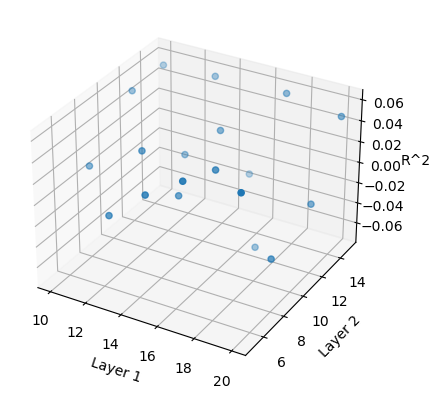

,Layer 1,Layer 2,R^2
0,20,15,0.04659373934070269
1,20,12,-0.012006072948376337
2,20,8,-0.02828045468777418
3,20,5,0.05999580770730972
4,17,15,0.05493433400988579
5,17,12,-0.07019568638255198
6,17,8,0.039914278934399285
7,17,5,0.05531571805477142
8,15,15,-0.03338830545544624
9,15,12,0.03426269255578518


In [51]:
lst = ['0.00012679751186321178,',
 '0.04659373934070269',
 '0.00012961790586511293,',
 '-0.012006072948376337',
 '0.00013100974805032214,',
 '-0.02828045468777418',
 '0.0001264953607460484,',
 '0.05999580770730972',
 '0.00012811090952406326,',
 '0.05493433400988579',
 '0.0001349946930228422,',
 '-0.07019568638255198',
 '0.00012885503141054264,',
 '0.039914278934399285',
 '0.0001271396758966148,',
 '0.05531571805477142',
 '0.00013046092741812268,',
 '-0.03338830545544624',
 '0.00012863553032123795,',
 '0.03426269255578518',
 '0.0001318168118208026,',
 '0.005822330092390378',
 '0.00012706543202511966,',
 '0.032719031597177185',
 '0.00012825140341495475,',
 '0.05356289198001226',
 '0.0001338832031857843,',
 '0.0014719826479752858',
 '0.00013106546248309314,',
 '0.038329625191787876',
 '0.00012857574135220298,',
 '0.0033810151120026908',
 '0.00012896229842832932,',
 '0.05141873595615228',
 '0.00012718407864061496,',
 '0.04944558752079805',
 '0.00012919132132083178,',
 '0.009466464320818583']
print(len(lst))
l1, l2 = [], []
for layer1 in [20, 17, 15, 13, 10]:
    for layer2 in [15, 12, 8, 5]:
        l1.append(layer1)
        l2.append(layer2)
d = [lst[i] for i in range(1, len(lst), 2)]
print(d[-1])
l1.pop()
l2.pop()
print(len(d), len(l1), len(l2))
res = pd.DataFrame({'Layer 1': l1, 'Layer 2': l2, 'R^2': d})
#res = pd.DataFrame(columns=['Layer 1', 'Layer 2', 'R^2'], data=[np.array(l1).reshape(-1,1), np.array(l2).reshape(-1,1), np.array(d).reshape(-1,1)])

#print(res)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = res["Layer 1"]
y = res["Layer 2"]
z = res["R^2"]

ax.scatter(np.array(x), np.array(y), np.array(z).astype('float32'))
ax.set_xlabel('Layer 1')
ax.set_ylabel('Layer 2')
ax.set_zlabel('R^2')

plt.show()

from IPython.display import display
display(res)

In [52]:
# Create a function to fit and predict the model with given layers
import matplotlib.pyplot as plt
def fit_and_predict(activation='sigmoid', l1=0, l2=0, l3=0):
    results = pd.DataFrame(columns=['Layer 1', 'Layer 2', 'Layer 3', 'R^2', 'Loss'])
    layer1, layer2, layer3 = 20, 20, 5
    for i in range(len((layer1, layer2, layer3))):
        res = pd.DataFrame(columns=['Layer 1', 'Layer 2', 'Layer 3', 'R^2', 'Loss'])
        for diff in range(0, -19, -1 + (-1 * i==2)):
            trials = [0, 0]
            for trial in range(3):
                model = keras.Sequential([
                            Dense(layer1 + (i==0) * diff, activation=activation,input_shape=(X_train_scaled.shape[1], )),
                            Dense(layer2 + (i==1) * diff, activation=activation),
                            Dense((10 + diff//2 )if (i==2) else layer3, activation=activation),
                            Dense(1)
                        ])
                optimizer = Adam(learning_rate=0.001)
                model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[r2])
                model.fit(X_train_scaled, y_train, epochs=150, batch_size=150, verbose=0)
                loss, r_2 = model.evaluate(X_test_scaled, y_test, verbose=0)
                trials[0] += loss
                trials[1] += r_2
            loss, r_2 = trials[0]/3, trials[1]/3
            res = pd.concat([res, pd.DataFrame({
                'Layer 1': layer1 + (i==0) * diff,
                'Layer 2': layer2 + (i==1) * diff,
                'Layer 3': (10 + diff//2 )if (i==2) else layer3,
                'R^2': r_2,
                'Loss': loss
            }, index=['Layer 1'])], ignore_index=True)
        res = res.sort_values(by=f'Layer {i+1}', ascending=False)
        # create a line plot with Layer 1 on the x-axis and R^2 on the y-axis
        plt.plot(res[f'Layer {i+1}'], res['R^2'])
        # set the axis labels and title
        plt.xlabel(f'Layer {i+1}')
        plt.ylabel('R^2')
        plt.title(f'R^2 vs Layer {i+1}')
        # display the plot
        plt.show()
        print(res.head())
        # Sort the dataframe by R^2 value
        results = pd.concat([results, res], axis=0)
    results = results.sort_values(by='R^2', ascending=False)
    return results

results = fit_and_predict()

153/153 [==============================] - 0s 1ms/step - loss: 2.0029e-04 - r2: -0.0597
MSE: 0.00020028636208735406
R^2:-0.05972958728671074


In [59]:
from IPython.display import display
display(results)


,Layer 1,Layer 2,Layer 3,R^2,Loss
14,20,6,5,0.084120,0.000125
0,20,20,5,0.079891,0.000127
1,20,19,5,0.079323,0.000125
9,20,11,5,0.076419,0.000124
13,20,7,5,0.075645,0.000125
17,20,20,1,0.075186,0.000125
12,20,8,5,0.074956,0.000125
2,20,18,5,0.074538,0.000127
18,20,20,1,0.073379,0.000125
10,20,10,5,0.071402,0.000126


In [ ]:
def test_regularization():
    l1 = 0.001
    while(l1 < 100):

In [53]:
def try_test_size(X, y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    l1_lambda = 0.1
    l2_lambda = 0.1
    model = keras.Sequential([
        Dense(5, activation='sigmoid', kernel_regularizer=regularizers.l1(l1_lambda), input_shape=(X_train_scaled.shape[1], )),
        Dense(5, activation='sigmoid', kernel_regularizer=regularizers.l2(l2_lambda)),
        Dense(1)
    ]) 
    optimizer = Adam(learning_rate=0.0001) # Tried out 0.01 learning rate, not much different. 0.001 is the default. Lowering learning rate gives steady descent, nice
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[r2])
    fit = model.fit(X_train_scaled, y_train,
                epochs=150,
                batch_size=150,
                verbose=0)
    loss, r_2 = model.evaluate(X_test_scaled, y_test)
    history = fit.history
    history['loss'] = history['loss'][-1]
    history['r2'] = history['r2'][-1]
    history['test_size'] = test_size
    return history, {'test_size': test_size, 'loss': loss, 'r2': r_2}

In [54]:
# Will probably shift into a different file later
from sklearn.feature_selection import mutual_info_regression
scores = mutual_info_regression(X_train_scaled, y_train)
for i in range(len(scores)):
    print(f"Feature {X_df.columns[i]} has a score of {scores[i]}")

Feature Danceability has a score of 0.10254484885413273
Feature Energy has a score of 0.10831805295390318
Feature Key has a score of 0.07992891854670336
Feature Loudness has a score of 0.10597676322519423
Feature Speechiness has a score of 0.1342366597874891
Feature Acousticness has a score of 0.12812963653481635
Feature Instrumentalness has a score of 0.06805801014504542
Feature Liveness has a score of 0.10173742783263506
Feature Valence has a score of 0.1180535551220796
Feature Tempo has a score of 0.11640778082598757
Feature Duration_ms has a score of 0.16926893084116923
Feature Stream has a score of 0.18365123144701734


In [55]:
y

array([0.00896958, 0.01498547, 0.03344874, ..., 0.00922965, 0.01347008,
       0.01565247], dtype=float32)

In [56]:
history, eval = try_test_size(X, y, 0.33)

202/202 [==============================] - 0s 1ms/step - loss: 2.0462e-04 - r2: -0.0629


In [69]:
cols = ['test_size', 'loss', 'r2']
training_error = pd.DataFrame(columns=cols)
test_error = pd.DataFrame(columns=cols)

for i in range(1, 50, 1):
    test_size = i / 100
    history, eval = try_test_size(X, y, test_size)
    training_error = pd.concat([training_error, pd.DataFrame(history, index=['test_size'])], ignore_index=True)
    test_error = pd.concat([test_error, pd.DataFrame(eval, index=['test_size'])], ignore_index=True)

display(training_error.head())
display(test_error.head())

282/282 [==============================] - 1s 2ms/step - loss: 2.0647e-04 - r2: nan


C:\Users\14086\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


300/300 [==============================] - 1s 2ms/step - loss: 2.7372e-04 - r2: -0.0380


,test_size,loss,r2
0,0.01,0.000201,-0.009924
1,0.02,0.000194,-0.007679
2,0.03,0.000198,-0.007647
3,0.04,0.000195,-0.009706
4,0.05,0.000190,-0.009875


,test_size,loss,r2
0,0.01,0.000178,-0.087068
1,0.02,0.000159,-0.053813
2,0.03,0.000173,-0.044264
3,0.04,0.000159,-0.079487
4,0.05,0.000162,-0.056892


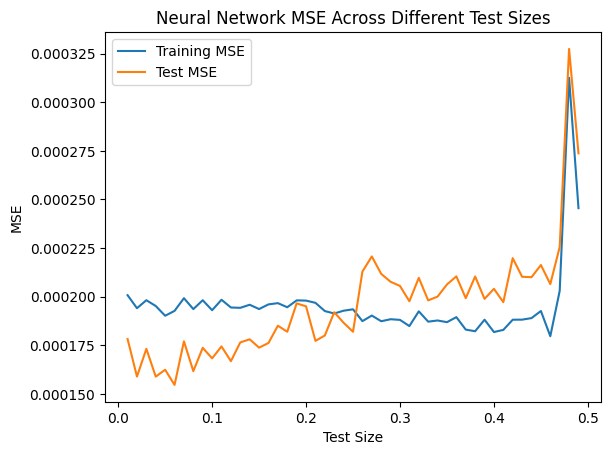

In [73]:
plt.figure()
plt.plot(training_error['test_size'], training_error['loss'], label='Training MSE')
plt.plot(test_error['test_size'], test_error['loss'], label='Test MSE')
plt.title('Neural Network MSE Across Different Test Sizes')
plt.xlabel('Test Size')
plt.ylabel('MSE')
plt.legend()
plt.show()

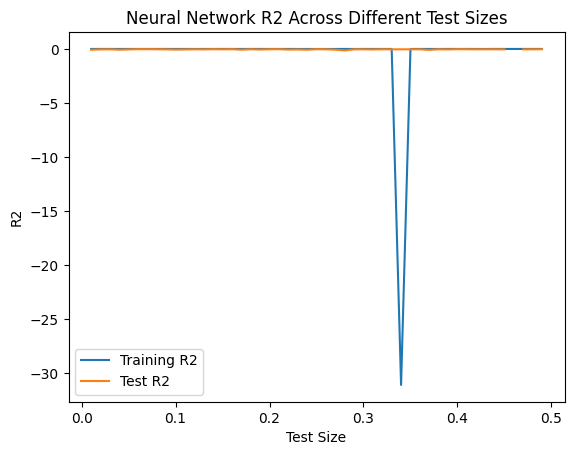

In [74]:
plt.figure()
plt.plot(training_error['test_size'], training_error['r2'], label='Training R2')
plt.plot(test_error['test_size'], test_error['r2'], label='Test R2')
plt.title('Neural Network R2 Across Different Test Sizes')
plt.xlabel('Test Size')
plt.ylabel('R2')
plt.legend()
plt.show()